# Use `CSV` for Custom Datasets

# Installing Anomalib

The easiest way to install anomalib is to use pip. You can install it from the command line using the following command:

In [ ]:
%pip install anomalib

## Setting up the Dataset Directory

This cell ensures we change the directory to have access to the datasets.

In [1]:
from pathlib import Path

# NOTE: Provide the path to the dataset root directory.
#   If the dataset is not downloaded, it will be downloaded
#   to this directory.
dataset_root = Path.cwd().parent.parent / "datasets" / "hazelnut_toy"

## Use CSV Dataset (for Custom Datasets) via API

Here we show how to utilize custom datasets to train anomalib models using the CSV datamodule. The CSV datamodule allows for more flexible dataset organization, where image paths and labels are specified in a CSV file.

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.v2 import Resize
from torchvision.transforms.v2.functional import to_pil_image

from anomalib import TaskType
from anomalib.data.image.csv import CSV, CSVDataset

### Creating a CSV file for the dataset

First, let's create a CSV file that contains the image paths and labels for our hazelnut dataset.

In [3]:
def create_csv_file(dataset_path: Path, csv_filename: str = "hazelnut_dataset.csv") -> Path:
    """Create a CSV file from the hazelnut dataset.

    Args:
        dataset_path (Path): Path to the hazelnut dataset.
        csv_filename (str, optional): Name of the CSV file.
            Defaults to "hazelnut_dataset.csv".

    Returns:
        Path: Path to the created CSV file.
    """
    data = []
    for category in ["good", "crack"]:
        image_dir = dataset_path / category
        for image_path in image_dir.glob("*.jpg"):
            mask_path = dataset_path / "mask" / category / image_path.name if category != "good" else ""
            data.append(
                {
                    "image_path": str(image_path),
                    "label": "normal" if category == "good" else "abnormal",
                    "mask_path": str(mask_path) if mask_path else "",
                },
            )

    data_frame = pd.DataFrame(data)
    csv_path = Path(csv_filename)
    data_frame.to_csv(csv_path, index=False)
    return csv_path


csv_file_path = create_csv_file(dataset_root)
print(f"CSV file created at: {csv_file_path}")

# Display the first few rows of the CSV file
pd.read_csv(csv_file_path).head()

CSV file created at: hazelnut_dataset.csv


,image_path,label,mask_path
0,/home/sakcay/Projects/anomalib/datasets/hazeln...,normal,NaN
1,/home/sakcay/Projects/anomalib/datasets/hazeln...,normal,NaN
2,/home/sakcay/Projects/anomalib/datasets/hazeln...,normal,NaN
3,/home/sakcay/Projects/anomalib/datasets/hazeln...,normal,NaN
4,/home/sakcay/Projects/anomalib/datasets/hazeln...,normal,NaN


### DataModule

Now that we have created a CSV file for our dataset, let's create an Anomalib datamodule using the CSV class.

In [4]:
csv_datamodule = CSV(
    name="hazelnut_toy",
    csv_path=csv_file_path,
    task=TaskType.SEGMENTATION,
    image_size=(256, 256),
)
csv_datamodule.setup()

In [5]:
# Train images
i, data = next(enumerate(csv_datamodule.train_dataloader()))
print("Train data:", data.keys(), data["image"].shape)

Train data: dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([21, 3, 256, 256])


In [6]:
# Test images
i, data = next(enumerate(csv_datamodule.test_dataloader()))
print("Test data:", data.keys(), data["image"].shape, data["mask"].shape)

Test data: dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([10, 3, 256, 256]) torch.Size([10, 256, 256])


Let's visualize a sample from the test dataloader.

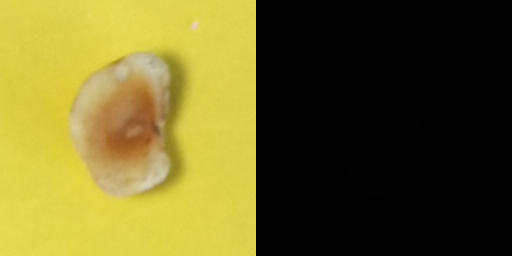

In [7]:
img = to_pil_image(data["image"][0].clone())
msk = to_pil_image(data["mask"][0]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))

### Torch Dataset

We can also create a standalone PyTorch dataset instance using the CSVDataset class.

In [8]:
CSVDataset??

Init signature:
CSVDataset(
    name: str,
    csv_path: str | pathlib.Path,
    task: str | anomalib.TaskType,
    split: Optional[Literal['train', 'val', 'test']] = None,
    sep: str | None = None,
    extension: str | list[str] | None = None,
    transform: torchvision.transforms.v2._transform.Transform | None = None,
) -> None
Source:        
class CSVDataset(AnomalibDataset):
    """Custom dataset class for image data loaded from a CSV file.

    This dataset class extends AnomalibDataset and provides methods to
    load data from a CSV file.

    Args:
        name (str): Name of the dataset. This is used to name the datamodule,
            especially when logging/saving.
        csv_path (str | Path): Path to the CSV file containing image data.
        task (str | TaskType): Task type for the dataset.
            Must be a valid TaskType enum value such as
            ``classification`` and ``segmentation``.
        split: Dataset split to filter (i.e., 'train', 'val', 'test').

Let's add a transform that resizes the input image to 256x256 pixels.

In [9]:
image_size = (256, 256)
transform = Resize(image_size, antialias=True)

#### Classification Task

In [10]:
csv_dataset_classification = CSVDataset(
    name="hazelnut_toy",
    csv_path=csv_file_path,
    transform=transform,
    task="classification",  # or TaskType.CLASSIFICATION,
)
csv_dataset_classification.samples.head()

,image_path,label,mask_path,label_index,split
0,/home/sakcay/Projects/anomalib/datasets/hazeln...,abnormal,/home/sakcay/Projects/anomalib/datasets/hazeln...,1,test
1,/home/sakcay/Projects/anomalib/datasets/hazeln...,abnormal,/home/sakcay/Projects/anomalib/datasets/hazeln...,1,test
2,/home/sakcay/Projects/anomalib/datasets/hazeln...,abnormal,/home/sakcay/Projects/anomalib/datasets/hazeln...,1,test
3,/home/sakcay/Projects/anomalib/datasets/hazeln...,abnormal,/home/sakcay/Projects/anomalib/datasets/hazeln...,1,test
4,/home/sakcay/Projects/anomalib/datasets/hazeln...,abnormal,/home/sakcay/Projects/anomalib/datasets/hazeln...,1,test


In [11]:
data = csv_dataset_classification[0]
print(data.keys(), data["image"].shape, data["image_path"], data["label"])

dict_keys(['image_path', 'label', 'image']) torch.Size([3, 256, 256]) /home/sakcay/Projects/anomalib/datasets/hazelnut_toy/crack/01.jpg 1


#### Segmentation Task

In [12]:
csv_dataset_segmentation = CSVDataset(
    name="hazelnut_toy",
    csv_path=csv_file_path,
    transform=transform,
    task="segmentation",  # TaskType.SEGMENTATION,
)
csv_dataset_segmentation.samples.head(10)

,image_path,label,mask_path,label_index,split
0,/home/sakcay/Projects/anomalib/datasets/hazeln...,abnormal,/home/sakcay/Projects/anomalib/datasets/hazeln...,1,test
1,/home/sakcay/Projects/anomalib/datasets/hazeln...,abnormal,/home/sakcay/Projects/anomalib/datasets/hazeln...,1,test
2,/home/sakcay/Projects/anomalib/datasets/hazeln...,abnormal,/home/sakcay/Projects/anomalib/datasets/hazeln...,1,test
3,/home/sakcay/Projects/anomalib/datasets/hazeln...,abnormal,/home/sakcay/Projects/anomalib/datasets/hazeln...,1,test
4,/home/sakcay/Projects/anomalib/datasets/hazeln...,abnormal,/home/sakcay/Projects/anomalib/datasets/hazeln...,1,test
5,/home/sakcay/Projects/anomalib/datasets/hazeln...,normal,,0,train
6,/home/sakcay/Projects/anomalib/datasets/hazeln...,normal,,0,train
7,/home/sakcay/Projects/anomalib/datasets/hazeln...,normal,,0,train
8,/home/sakcay/Projects/anomalib/datasets/hazeln...,normal,,0,train
9,/home/sakcay/Projects/anomalib/datasets/hazeln...,normal,,0,train


In [13]:
data = csv_dataset_segmentation[5]  # Choose an abnormal sample
print(data.keys(), data["image"].shape, data["mask"].shape)

dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([3, 256, 256]) torch.Size([256, 256])


Let's visualize the image and the mask...

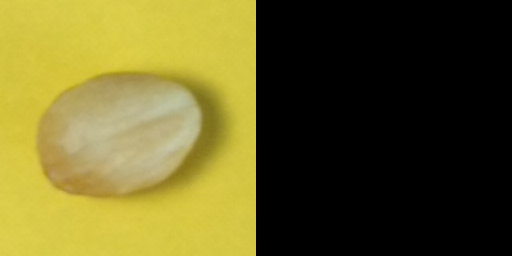

In [14]:
img = to_pil_image(data["image"].clone())
msk = to_pil_image(data["mask"]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))

It is also possible to create a CSV dataset with train, validation, and test splits. For more details, you could check out the documentation [here](https://anomalib.readthedocs.io/en/v1.0.1/markdown/guides/reference/data/image/csv.html)